<a href="https://colab.research.google.com/github/Ignaciojeda/ProyectoCSSCrisDm/blob/main/Regresion_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar librerias

In [15]:
# Librerías generales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder




#Importar DataSet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
# Cargar los datos
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Mounted at /content/drive
Datos cargados exitosamente!


# Analisis de la variable Survived

Distribución de la variable objetivo (¿Sobrevive el jugador?):
Survived
False    47214
True     31943
Name: count, dtype: int64


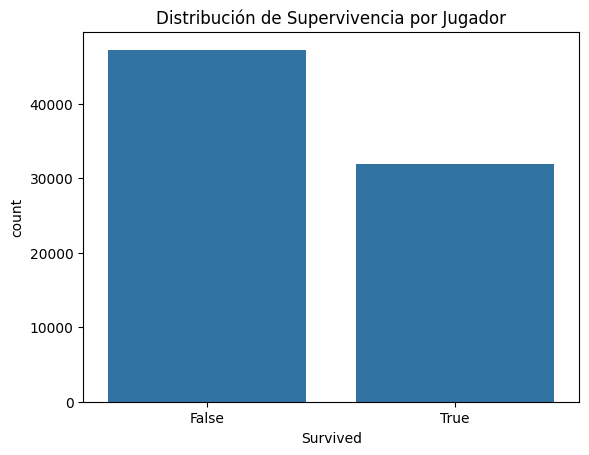

In [4]:
print("Distribución de la variable objetivo (¿Sobrevive el jugador?):")
print(data['Survived'].value_counts())
sns.countplot(x='Survived', data=data)
plt.title("Distribución de Supervivencia por Jugador")
plt.show()


#Separar Variables

In [5]:
columnas_usadas = ['Survived', 'RoundWinner', 'Team', 'Map', 'RoundStartingEquipmentValue']
df = data[columnas_usadas].dropna().copy()

# Codificar variables categóricas
le_team = LabelEncoder()
le_map = LabelEncoder()
le_winner = LabelEncoder()

df['Team'] = le_team.fit_transform(df['Team'])
df['Map'] = le_map.fit_transform(df['Map'])
df['RoundWinner'] = le_winner.fit_transform(df['RoundWinner'])


In [6]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)


#Entrenamiento del modelo

In [7]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#Predicciones

In [8]:
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.677151760148223

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.77      0.66      0.71     14216
        True       0.58      0.70      0.64      9532

    accuracy                           0.68     23748
   macro avg       0.67      0.68      0.67     23748
weighted avg       0.69      0.68      0.68     23748


Matriz de confusión:
[[9389 4827]
 [2840 6692]]


#Prediccion de supervivencia

In [9]:
# Probabilidad de sobrevivir (clase 1)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Mostrar primeras 10
print(y_proba[:10])


[0.58259797 0.61222965 0.19122499 0.25342369 0.26486965 0.56903308
 0.18008092 0.2690095  0.59798328 0.1901367 ]


#Cuanto influye

In [11]:
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': logreg.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

print(coef_df)


                      Variable  Coeficiente
2                          Map     0.007052
3  RoundStartingEquipmentValue     0.000081
1                         Team    -0.066677
0                  RoundWinner    -0.731700


#Modelar visualmente

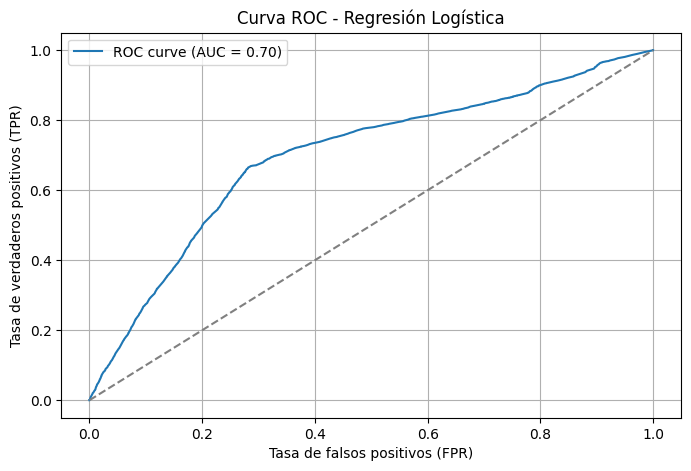

In [14]:
y_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid()
plt.show()


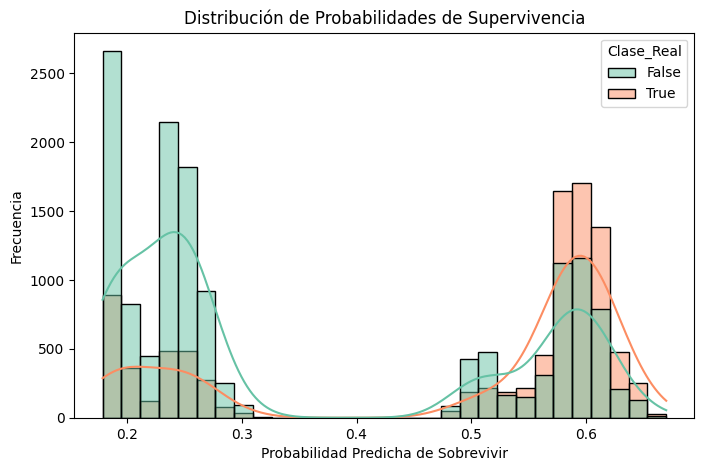

In [12]:
df_proba = pd.DataFrame({
    'Probabilidad_Sobrevivir': y_proba,
    'Clase_Real': y_test.reset_index(drop=True)
})

plt.figure(figsize=(8, 5))
sns.histplot(data=df_proba, x='Probabilidad_Sobrevivir', hue='Clase_Real', bins=30, kde=True, palette='Set2')
plt.title('Distribución de Probabilidades de Supervivencia')
plt.xlabel('Probabilidad Predicha de Sobrevivir')
plt.ylabel('Frecuencia')
plt.show()


##Analisis


In [17]:
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.677151760148223

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.77      0.66      0.71     14216
        True       0.58      0.70      0.64      9532

    accuracy                           0.68     23748
   macro avg       0.67      0.68      0.67     23748
weighted avg       0.69      0.68      0.68     23748


Matriz de confusión:
[[9389 4827]
 [2840 6692]]


**1. Exactitud General (Accuracy): 0.68**
El modelo predice correctamente en el 68% de los casos.

Este valor es aceptable, especialmente considerando que el problema no está perfectamente balanceado (más ejemplos de False que de True).

**Interpretación:**

Clase False (No sobrevive):

Alta precisión: cuando el modelo predice que alguien no sobrevive, suele acertar.

Pero menor recall: a veces no detecta correctamente a los que realmente no sobreviven.

Clase True (Sobrevive):

Menor precisión: hay más falsos positivos (predice que sobrevive, pero no).

Buen recall: detecta bien a quienes sí sobreviven.

